# How Much Damage Can I Do Turbo-Punting Shit Coins?

Here in Australia, we're right in the depths of the silly season. We indulge in long lunches, take days off work, and generally let our hair down. 

In that spirit, I thought I might have some fun punting shitcoins. 

(Maybe my definition of fun differs from yours, but let's run with it).

For the uninitiated, the technical definition of a shitcoin is a recently launched cryptocurrency of dubious economic value and marginal liquidity.  

These things have historically shown a noisy tendency to trend, which means that if you can be bothered trading them (marginal liquidity and all that) and don't mind taking on the very real risk of total capital incineration, you can potentially make some money with simple trend-following rules.

A while back we looked at a simple trend-following strategy where we get long anything within 5 days of its 20-day high:

<img src="https://storage.googleapis.com/rw-blog-images/turbo-ape.png" width="700" height="420"/>

As part of my homage to the silly season, I intend to throw a small amount of capital at this strategy, turn it up to full noise, and see how we go. 

But I'd like to do it at least somewhat sensibly and systematically. 

To that end, I'll manage the strategy to a drawdown target by reducing the leverage as a function of drawdown from all time equity highs. I'll be turbo long (5x leverage) when I'm at all time highs, and I'll be at 0 leverage when I'm drawn down 90% from all time highs. I'll reduce my leverage linearly between these two extremes as a function of drawdown. 

But these are illiquid shitcoins that are flying around all over the place. I don't want to be constantly rebalancing - that'd be a full time job. My silly season would quickly turn into boring season. 

So how often should I rebalance things? What are the implications of rebalancing more or less frequently?

One way to answer that is through simulation - we can generate a statistically significant number of random outcomes and see how our decisions about leverage played out. Our results are only as good as our assumptions that go into the simulator, but even if those assumptions are off, we can still gain some important intuition. 

In this case, I'll set up a Geometric Brownian Motion (GBM) simulator and generate a ton of different random price series that look like shitcoin prices. 

A while back, I shared some code for generating GBM price series using vectorisation. You can check it out [here](https://robotwealth.com/efficiently-simulating-geometric-brownian-motion-in-r/).

But this time, I want to add some proper shitcoin dynamics: 
- These things tend to show some autocorrelation (hence why trend following has worked on these in the past)
- They tend to be quite jumpy

I'll add some autocorrelation using an autorgressive process. And I'll add some random jumps via a jump diffusion process. 

These things make the vectorised approach impossible, since subsequent values depend on previous ones. 

But to speed things up, we'll outsource the autoregressive and jump diffusion components to a C++ function and call that from our R session. 

Let's get to it.

In [3]:
# session options
options(repr.plot.width = 14, repr.plot.height=7, warn=-1)

# load and install packages
install.packages("tibbletime")  # Rcpp is a dependency
install.packages("patchwork")
install.packages("tidyverse")

library(tidyverse)
library(tibbletime)
library(patchwork)
library(Rcpp)

# set chart options
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'tibbletime'


The following object is masked from 'package:stats':

    filter




In [4]:
# hourly GBM simulator with autocorrelation and jump diffusion

# C++ function for doing the autogregressive and jump diffusion bit
cppFunction("
NumericMatrix generateAR1WithJumps(int nsim, int t, double phi, double lambda, double mu_j, double sigma_j) {
  NumericMatrix epsilon(t-1, nsim);
  NumericVector eta(nsim);
  NumericVector jumpSize(nsim);

  // Initial values from normal distribution
  for(int j = 0; j < nsim; ++j) {
    epsilon(0, j) = R::rnorm(0, 1);
  }

  // AR(1) process with jumps
  for(int i = 1; i < t-1; ++i) {
    for(int j = 0; j < nsim; ++j) {
      eta[j] = R::rnorm(0, 1);
      epsilon(i, j) = phi * epsilon(i-1, j) + eta[j];
      
      // Generate jumps
      if(R::runif(0, 1) < lambda) {
        jumpSize[j] = R::rnorm(mu_j, sigma_j);
        epsilon(i, j) += jumpSize[j];
      }
    }
  }
  
  return epsilon;
}
")

# gbm generator function
#' @param phi: autocorrelation
#' @param lambda: jump intensity
#' @param mu_j @param sigma_j: define the distribution of the jump sizes 
#' other params as per standard GBM model
#' NOTE simulates hourly prices using annualised volatility and returns
gbm_autocor_jumps <- function(nsim = 100, t = 25, mu = 0, sigma = 0.1, S0 = 100, dt = 1./(365*24), phi = 0.5, lambda = 0.01, mu_j = 0, sigma_j = 0.1) {
  
  # Use Rcpp function to generate epsilon with AR(1) and jumps
  epsilon <- generateAR1WithJumps(nsim, t, phi, lambda, mu_j, sigma_j)
  
  # get GBM and convert to price paths
  gbm <- exp((mu - sigma * sigma / 2) * dt + sigma * epsilon * sqrt(dt))
  gbm <- apply(rbind(rep(S0, nsim), gbm), 2, cumprod)

  return(gbm)
}

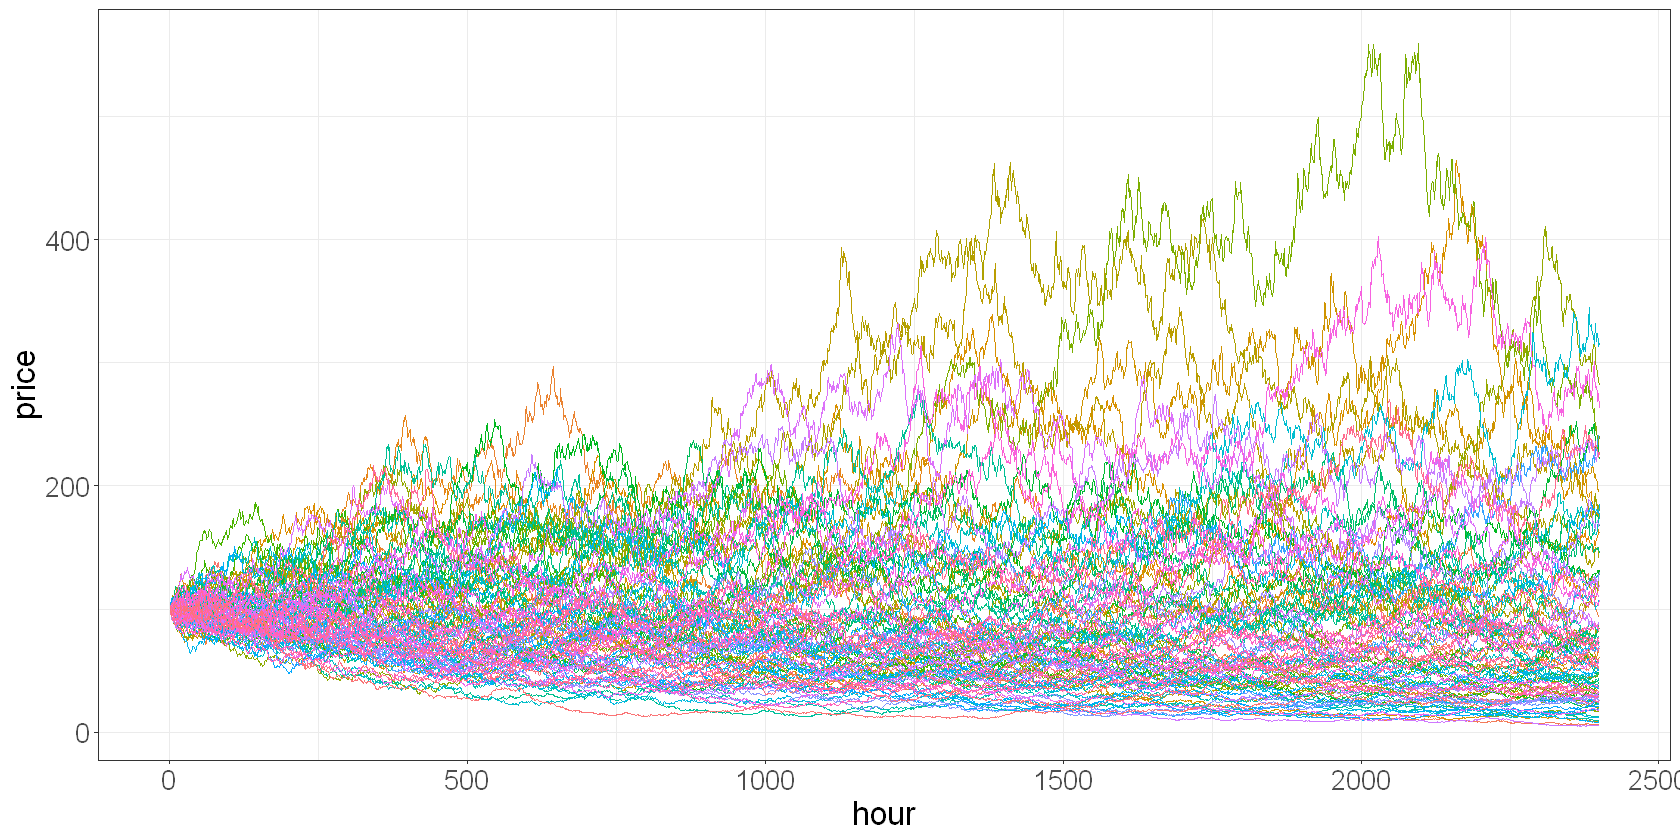

In [5]:
# make some random price series with shitcoin-like parameters
nsim <- 100
t <- 100*24  # 100 days
mu <- -1
sigma <- 1.5
S0 <- 100
phi <- 0.1

set.seed(503)  # so we can reproduce results
gbm <- gbm_autocor_jumps(nsim, t, mu, sigma, S0, phi = phi, lambda = 0.2, mu_j = 0, sigma_j = 1)

gbm_df <- as.data.frame(gbm) %>%
  mutate(ix = 1:nrow(gbm)) %>%
  pivot_longer(-ix, names_to = 'sim', values_to = 'price')

gbm_df %>%
  ggplot(aes(x=ix, y=price, color=sim)) +
  geom_line() +
  theme(legend.position = 'none') +
  labs(x = "hour")

Nice. That does indeed look a lot like a universe of shitcoin prices. 

Next calculate positions for the ape new highs strategy. We'll just ape new all time highs for 5 days. The details of the strategy aren't important, it's just for building intuition and getting a feel for the dynamics. 

In [6]:
# ape new highs strategy

# calculate positions
hold_period <- 5*24  # in hours

positions_df <- gbm_df %>%
  group_by(sim) %>%
  mutate(all_time_high = cummax(price)) %>%
  mutate(idx_all_time_high = match(all_time_high, unique(price))) %>%
  mutate(lagged_idx_all_time_high = dplyr::lag(idx_all_time_high)) %>%
  mutate(periods_since_high = ix - lagged_idx_all_time_high) %>%
  mutate(position = case_when(
    between(periods_since_high, 1, hold_period) & lagged_idx_all_time_high > 1 ~ 1, TRUE ~ 0
  ))

tail(positions_df)

ix,sim,price,all_time_high,idx_all_time_high,lagged_idx_all_time_high,periods_since_high,position
<int>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>
2400,V95,28.052307,216.5835,343,343,2057,0
2400,V96,226.873371,270.0969,2048,2048,352,0
2400,V97,58.261634,108.7399,15,15,2385,0
2400,V98,53.079638,111.8936,63,63,2337,0
2400,V99,32.888193,104.3259,46,46,2354,0
2400,V100,6.144701,120.5961,65,65,2335,0


Here's an example of when we'd be in a particular coin (blue marks):

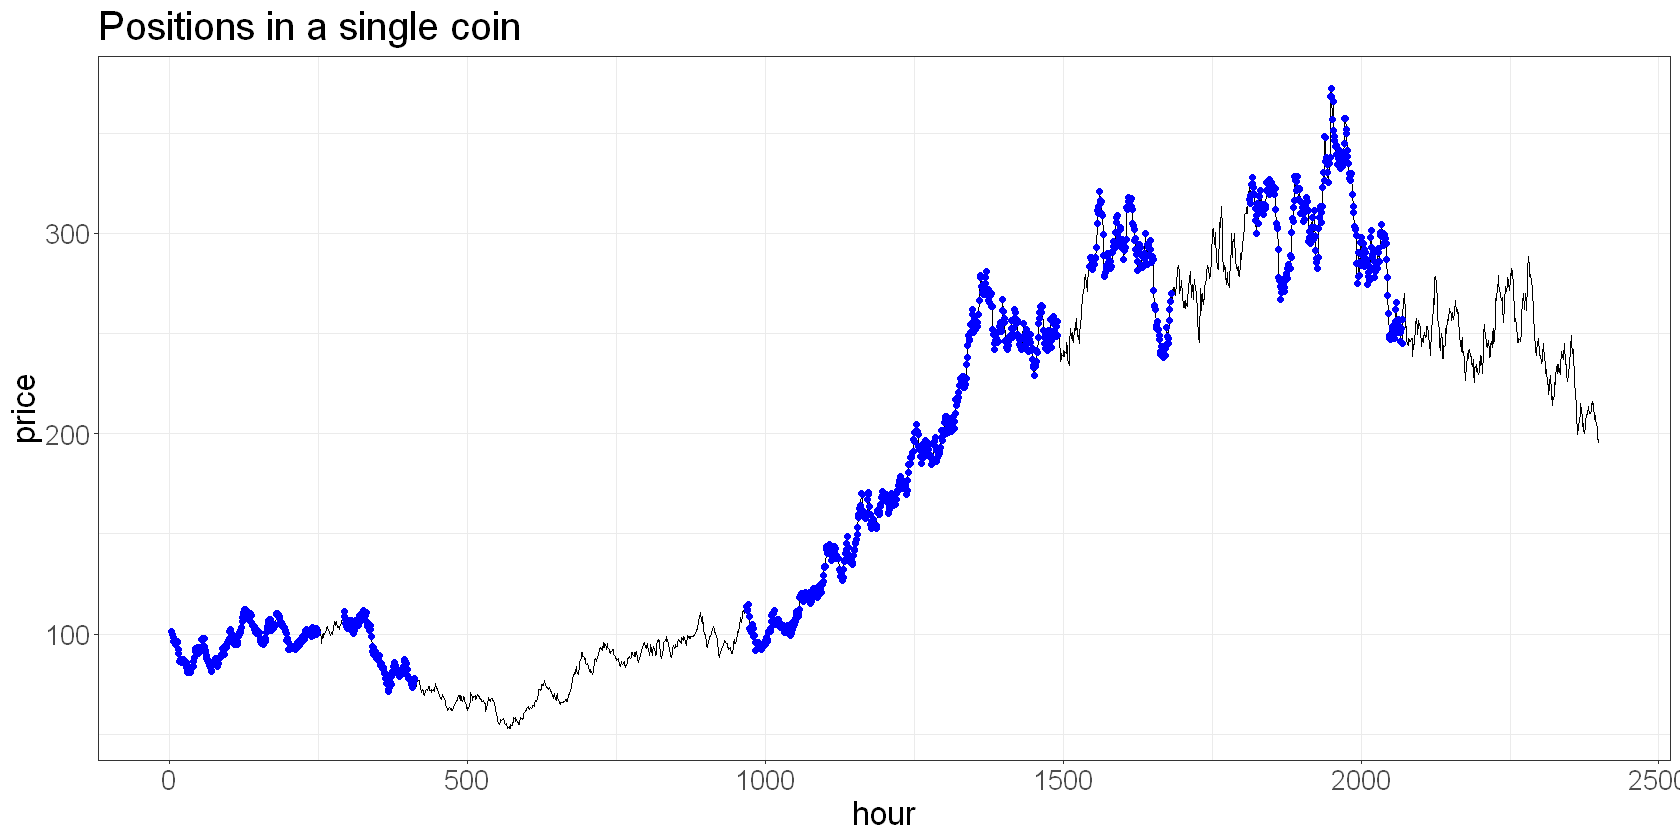

In [7]:
# example plot of when we're in a position for a given series
positions_df %>%
  mutate(position_plot = case_when(position == 1 ~ price, TRUE ~ NA_real_)) %>%
  filter(sim == "V2") %>%
  ggplot(aes(x = ix, y = price)) +
  geom_line() +
  geom_point(aes(x = ix, y = position_plot), colour = "blue") +
  labs(title = "Positions in a single coin", x = "hour")

Calculate simple returns to the strategy with no leverage:

In [8]:
# simple returns
returns_df <- positions_df %>%
  group_by(sim) %>%
  # assume we enter a position at the hourly price at which we make a new high 
  mutate(simple_return = (price - dplyr::lag(price))/dplyr::lag(price)) %>%
  mutate(strategy_simple_return = position*simple_return) %>%
  na.omit() %>%
  ungroup()

The next part is the tricky and fairly slow bit. 

We simulate the returns to the ape new highs strategy being managed to a drawdown target. 

It's a time-consuming operation because our target leverage depends on our current drawdown, and so we must do it all in a big `for` loop.  

Ideally I'd like to generate multiple universes of simulated shitcoins and then run this ape strategy simulation for each universe. That would generate a histogram of outcomes, rather than the single outcome we see here, enabling us to make probabilistic conclusions and extract further insight. 

I'll leave to you. For the purposes of this post, I'll just run it on the universe we generated previously. I'll simulate a rebalance period of 24 hours (or when a position changes). 

In [9]:
# will need to do in a for loop since actual leverage will be dependent on drawdown
# calculate portfolio pnl for each day 
# adjust leverage for next day if needs be (if we're at rebal frequency or positions change)

# need a function for defining how we modify our leverage
set_leverage <- function(max_leverage, current_drawdown, max_acceptable_drawdown=0.9) {
  # decrease leverage linearly with drawdown
  # in practive, you might want to decrease it faster - maybe some non-linear function
  leverage <- max(min(max_leverage - max_leverage/max_acceptable_drawdown*current_drawdown, max_leverage), 0)
  return(leverage)
}

# this bit is going to be slow
# could optimise by replacing dataframes with matrixes if we want to do lots
starting_leverage <- 5
rebalance_frequency <- 24  # in hours
starting_leverage <- 5
all_time_equity_high <- 1 # starting ATH
portfolio_results <- list()

for(i in min(returns_df$ix):max(returns_df$ix)) {
  if(i == min(returns_df$ix)) {
    # start by sizing all positions using starting leverage
    leverage <- starting_leverage
    num_positions <- returns_df %>%
      filter(ix == i) %>%
      # calculate current positions for target leverage
      summarise(num_positions = sum(position)) %>%
      pull(num_positions)
  
    size_per_position <- starting_leverage/num_positions

    # adjust positions for all future rows (these will be updated in subsequent steps)  
    returns_df <- returns_df %>%
      mutate(leveraged_position = position*size_per_position) %>%
      mutate(strategy_simple_return = leveraged_position*simple_return)
  }

  # calculate current positions for target leverage
  current_num_positions <- returns_df %>%
      filter(ix == i) %>%
      summarise(num_positions = sum(position)) %>%
      pull(num_positions)
  
  # assume we rebalance at the start of the period if we change positions or hit our rebalance frequency    
  if(i %% rebalance_frequency == 0 | current_num_positions != num_positions) {
    leverage <- set_leverage(starting_leverage, current_drawdown)

    if(current_num_positions > 0)
      size_per_position <- leverage/current_num_positions

    # adjust positions for all future rows (these will be updated in subsequent steps)  
    returns_df <- returns_df %>%
      mutate(leveraged_position = position*size_per_position) %>%
      mutate(strategy_simple_return = leveraged_position*simple_return)
  }

  num_positions <- current_num_positions
    
  # calculate leveraged portfolio returns
  leveraged_port_returns <- returns_df %>%
    filter(ix == i) %>%
    # leveraged portfolio returns will be the equal-weighted strategy returns scaled to the target leverage
    group_by(ix) %>%
    summarise(leveraged_returns = sum(strategy_simple_return, na.rm = TRUE)) %>%
    mutate(leverage = leverage)

  # store results
  portfolio_results[[i-1]] <- leveraged_port_returns
    
  # keep a running portfolio equity and drawdown
  current_port_returns <- portfolio_results %>%
    bind_rows() %>%
    # just use simple returns
    mutate(cum_port_returns = cumprod(1 + leveraged_returns)) %>%
    tail(1) %>%
    pull(cum_port_returns)
  
  all_time_equity_high <- max(current_port_returns, all_time_equity_high)
  current_drawdown <- all_time_equity_high - current_port_returns
}

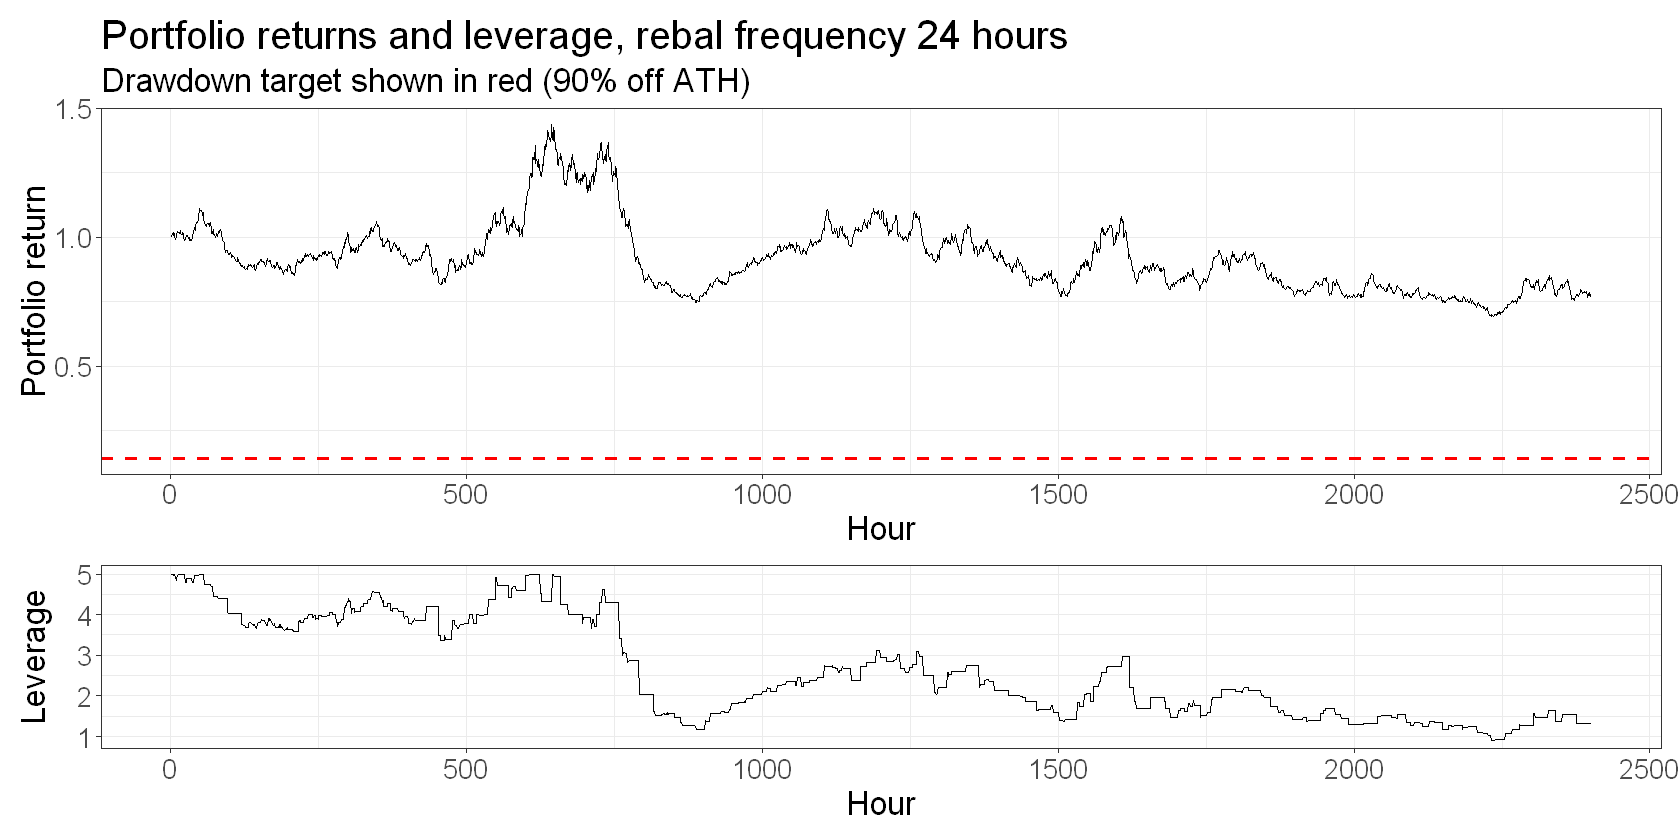

In [10]:
# plot results
results_df <- bind_rows(portfolio_results) %>%
  mutate(cum_port_returns = cumprod(1 + leveraged_returns)) 

# get all-time-high to plot drawdown target
drawdown_target <- max(results_df$cum_port_returns)*0.1

returns_plot <- results_df %>%
  ggplot(aes(x = ix, y = cum_port_returns)) +
  geom_line() +
  geom_hline(yintercept = drawdown_target, colour = "red", size = 1, linetype = "dashed") +
  labs(
    x = "Hour",
    y = "Portfolio return",
    title = glue::glue("Portfolio returns and leverage, rebal frequency {rebalance_frequency} hours"),
    subtitle = "Drawdown target shown in red (90% off ATH)"
  )

leverage_plot <- results_df %>%
  ggplot(aes(x = ix, y = leverage)) +
  geom_line() +
  labs(
    x = "Hour",
    y = "Leverage"
  )

returns_plot / leverage_plot + plot_layout(heights = c(2,1))

You can see in the plot above that the strategy performed dreadfully, at least on the particular simulated universe we generated here.

However, you can also see that I was able to manage it to a drawdown target rebalancing once every 24 hours (or whenever we got a new position), thus ensuring that my silly season wasn't totally ruined. 

## Summary

In this post, we shared an efficient way to generate Geometric Brownian Motion (GBM) price series that include autocorrelation and jumps. 

One can use such a tool to gain intuition into various noisy, random processes, such as turbo-punting shitcoins to a drawdown target. 

In this example, we used the GBM simulator to get a feel for how often we might need to rebalance an overly leveraged shitcoin trend-following strategy. We can run the simulator with various parameterisations and get a feel for how often we destroy our capital under different conditions, or how often we should think about rebalancing back to our target leverage. 

I hope you have as much fun as I intend to this silly season. 